# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

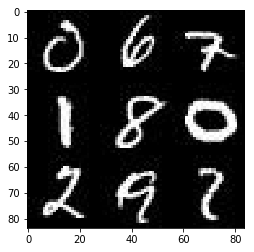

In [18]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

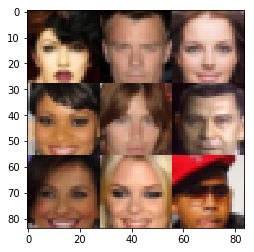

In [19]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_inputs")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_inputs, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
            # Input layer is 32x32x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(.2 * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(.2 * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(.2 * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(.1 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(.1 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(.1 * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    real_images, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_images, z_inputs, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                
                _ = sess.run(d_train_opt, feed_dict={real_images: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_images: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_inputs, out_channel_dim, data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples
                
                

In [30]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3822... Generator Loss: 5.5293
Epoch 1/2... Discriminator Loss: 3.9610... Generator Loss: 0.0257
Epoch 1/2... Discriminator Loss: 2.6347... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.6657
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.8601... Generator Loss: 2.6343
Epoch 1/2... Discriminator Loss: 1.6137... Generator Loss: 0.3623
Epoch 1/2... Discriminator Loss: 1.7768... Generator Loss: 0.2733
Epoch 1/2... Discriminator Loss: 1.6307... Generator Loss: 2.2290
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 1.7039


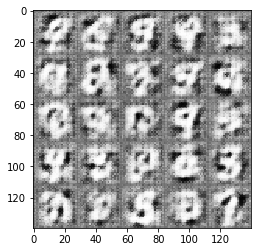

Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.3614
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 1.6468
Epoch 1/2... Discriminator Loss: 1.7769... Generator Loss: 0.2610
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 1.1929... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.4480
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 1.7398


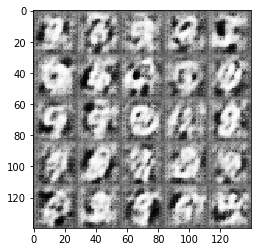

Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.4054
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.7074
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 2.6672
Epoch 1/2... Discriminator Loss: 1.5617... Generator Loss: 0.3560
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 2.2428
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.5106
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 1.2711


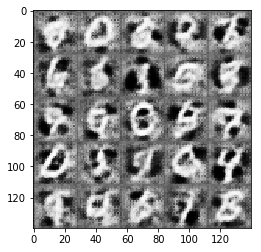

Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 1.8284
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 1.7620... Generator Loss: 0.2471
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 1.6526
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 0.8276


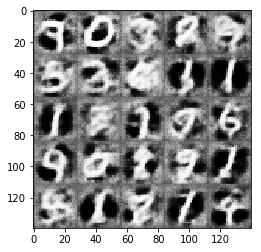

Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 1.5068
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 2.2853
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.2620
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.4009
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 1.6914
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 1.8028
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 0.8149


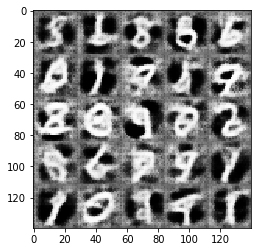

Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 2.2681
Epoch 2/2... Discriminator Loss: 1.6023... Generator Loss: 0.2868
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 1.2011... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.6045
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.6750


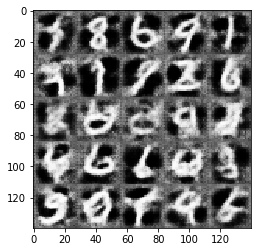

Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.5773
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 1.1354
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 2.1315
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.0427
Epoch 2/2... Discriminator Loss: 2.1325... Generator Loss: 2.9349
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.4593
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.3960
Epoch 2/2... Discriminator Loss: 1.5852... Generator Loss: 2.1362


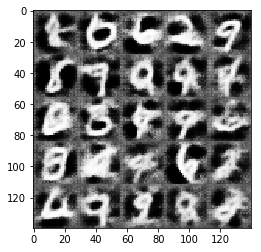

Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.6710
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.5649
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.5521... Generator Loss: 0.3236
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 1.3532
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.1495


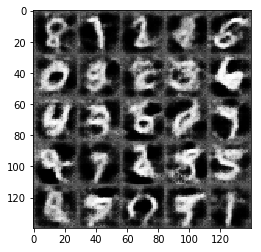

Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.5031
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 1.4427
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.3876
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.0568
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.8793


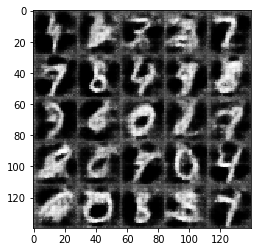

Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 0.8308


In [31]:
batch_size = 128
z_dim = 100
learning_rate = .0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 4.7264
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 6.3751
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 3.4251
Epoch 1/1... Discriminator Loss: 0.2504... Generator Loss: 3.1297
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 2.9872
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.4383


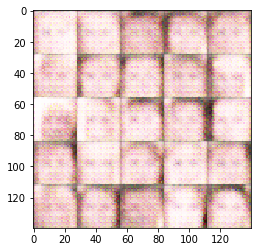

Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 2.8192
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 6.5441
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.2411... Generator Loss: 2.9320
Epoch 1/1... Discriminator Loss: 3.6773... Generator Loss: 0.0452
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 0.2681... Generator Loss: 2.3405
Epoch 1/1... Discriminator Loss: 0.3187... Generator Loss: 2.1565
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 2.3359


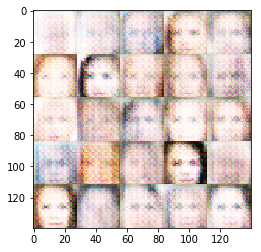

Epoch 1/1... Discriminator Loss: 2.1932... Generator Loss: 0.2228
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 4.7047
Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 2.6004... Generator Loss: 0.1283
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 1.8459
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 6.3956
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 4.4797
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9590


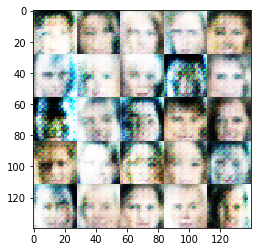

Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 0.3134... Generator Loss: 3.0307
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 2.0508
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 3.3673
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 1.9059... Generator Loss: 0.2264
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.4719


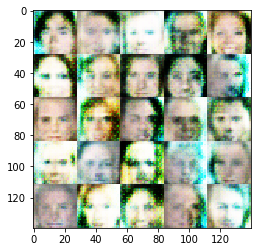

Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.7089... Generator Loss: 3.0748
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 4.3857
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 4.4862
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.6631... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 0.3237... Generator Loss: 2.9610


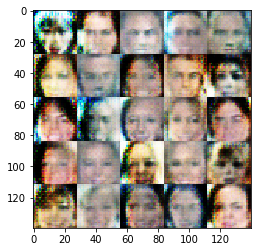

Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 0.2896... Generator Loss: 3.0316
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 3.0629... Generator Loss: 2.6570
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6964


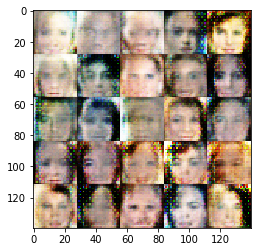

Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 1.8762
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 2.7470
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.2962... Generator Loss: 2.2597


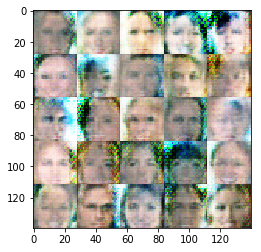

Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 2.1145... Generator Loss: 0.1632
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.2876
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 2.5179
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.2509
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8109


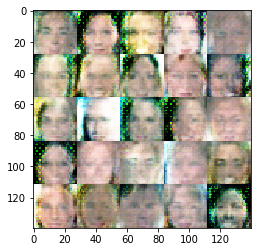

Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.7497
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 4.3841
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 3.8152
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.0642
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 3.3779
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.8738


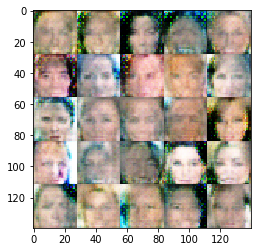

Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 1.2519
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 2.5951
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 4.3017
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 4.9745
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.8899
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.4426


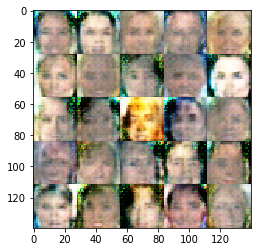

Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.8985... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.5076
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 3.3438
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 3.0956
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 2.6202
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 2.3476
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.3663


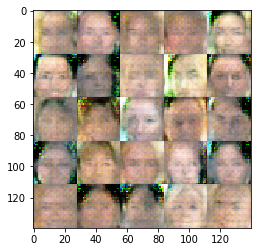

Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 1.7705
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 2.1909
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 3.3797
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 0.2600


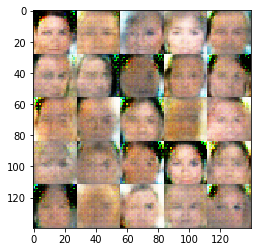

Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 2.3084
Epoch 1/1... Discriminator Loss: 1.9467... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 1.7533
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 2.4716... Generator Loss: 0.1426
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.3159
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.3702


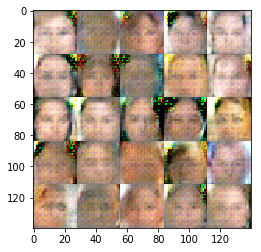

Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 2.8400
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.1764
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 2.0935... Generator Loss: 0.1634
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 2.5981
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 1.8077


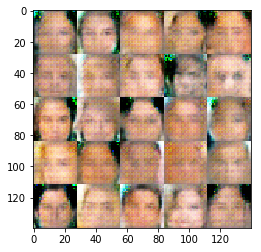

Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 3.5692
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 3.0540
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.1149


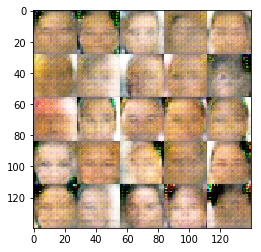

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 2.7715
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 3.7031
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.3025... Generator Loss: 1.9954
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 2.1293
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 2.5925


In [13]:
batch_size = 128
z_dim = 100
learning_rate = .0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.